In [1]:
# digit recognizer 0 to 9 using mnist Dataset

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time

In [3]:
# MNIST = datasets.mnist('data.csvmnist_trainset')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

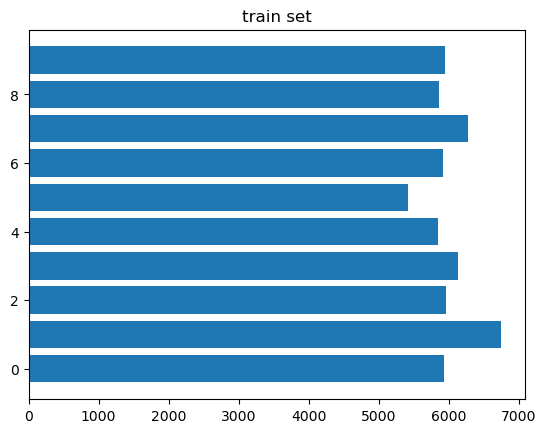

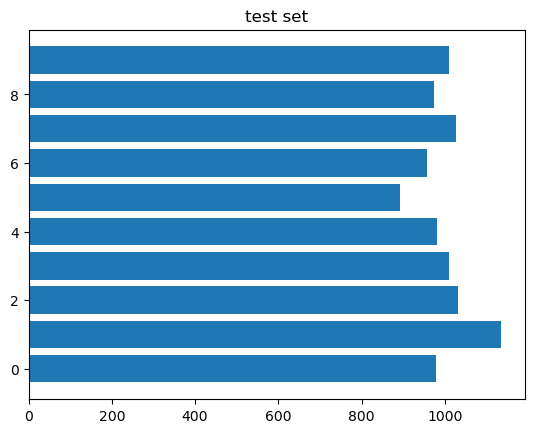

In [4]:
train_count = np.unique(mnist_trainset.targets.numpy(), return_counts=True)
test_count = np.unique(mnist_testset.targets.numpy(), return_counts=True)

plt.barh(y=train_count[0], width=train_count[1])
plt.title('train set')
plt.show()

plt.barh(y=test_count[0], width=test_count[1])
plt.title('test set')
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
X_train = mnist_trainset.data.to(device)
X_train = X_train.float()

y_train = mnist_trainset.targets.to(device)

X_test = mnist_testset.data.to(device)
X_test = X_test.float()

y_test = mnist_testset.targets.to(device)

X_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

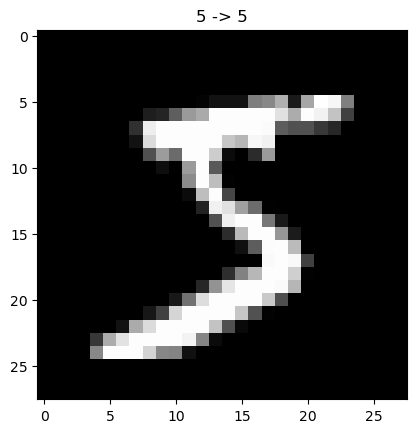

In [54]:
def show_img(data: torch.Tensor, y: torch.Tensor, pred: torch.Tensor, rows=1, columns=1):
    fig, axs = plt.subplots(rows, columns)
    plt.imshow(torch.Tensor.cpu(data).reshape(28,28,-1) , cmap='grey')
    plt.title(f'{y.item()} -> {pred.item()}')
    plt.show()
    
show_img(X_train[0],y_train[0],y_train[0])

In [24]:
class Model1(nn.Module): # without convolution layers
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        output = input.view(-1, 28*28)
        output = self.l1(output)
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [9]:
class Model2(nn.Module): # using CNN's 
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1
        
        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16
        
        output = output.view(-1, 16 * 4*4) # flattening
        # size = X * 256

        output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [47]:
def train(model: nn.Module, epochs: int, learning_rate: float) -> nn.Module:
    print(model.parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    for i in range(epochs):
        pred = model(X_train)
        loss = criterion(pred, y_train)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i % (epochs//10)==0):
            with torch.no_grad():
                pred_test = model(X_test)
                pred_test = torch.argmax(pred_test, dim=1)
            
                correct = (pred_test==y_test).sum().item()
                acc = 100 * (correct/y_test.size(dim=0))
                print(f'epoch = {i}/{epochs}')
                print(f'loss = {loss.item():.3f}')
                print(f'accuracy = {acc:.3f}', end=2*'\n')

    
    with torch.no_grad(): # not using evaluation(test) for gradient descent
        pred_test = model(X_test)
        pred_test = torch.argmax(pred_test, dim=1)
    
        correct = (pred_test==y_test).sum().item()
        acc = 100 * (correct/y_test.size(dim=0))
        print(f'epoch = {i+1}/{epochs}')
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2*'\n')
        
    end_time = time.time()
    print(f'total {end_time-start_time:.3f} seconds on {device}.')
    return model

In [51]:
epochs = 200
learning_rate = 0.0005

model1 = Model1(28*28, 40, 20).to(device)
model2 = Model2(4*4*16, 120, 80).to(device)

print("model 1")
train(model1, epochs=epochs, learning_rate=learning_rate)

print('\n'*5)

print("model 2")
model = train(model2, epochs=epochs, learning_rate=learning_rate) # saving trained conv-model

model 1
<bound method Module.parameters of Model1(
  (l1): Linear(in_features=784, out_features=40, bias=True)
  (l2): Linear(in_features=40, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)>
epoch = 0/200
loss = 2.351
accuracy = 10.470

epoch = 20/200
loss = 1.827
accuracy = 38.130

epoch = 40/200
loss = 1.743
accuracy = 64.070

epoch = 60/200
loss = 1.647
accuracy = 80.950

epoch = 80/200
loss = 1.620
accuracy = 83.060

epoch = 100/200
loss = 1.608
accuracy = 84.140

epoch = 120/200
loss = 1.599
accuracy = 85.020

epoch = 140/200
loss = 1.560
accuracy = 90.560

epoch = 160/200
loss = 1.527
accuracy = 92.810

epoch = 180/200
loss = 1.516
accuracy = 93.820

epoch = 200/200
loss = 1.510
accuracy = 94.410

total 2.046 seconds on cuda.






model 2
<bound method Module.parameters of Model2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (po

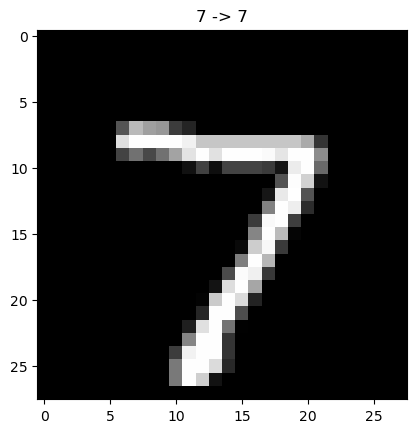

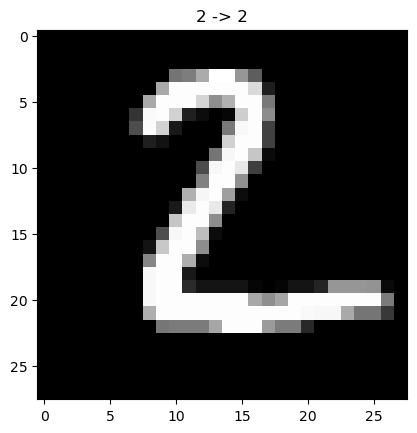

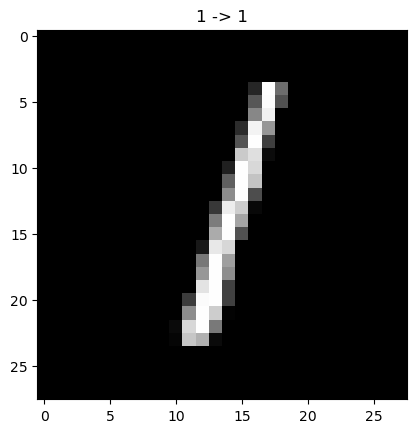

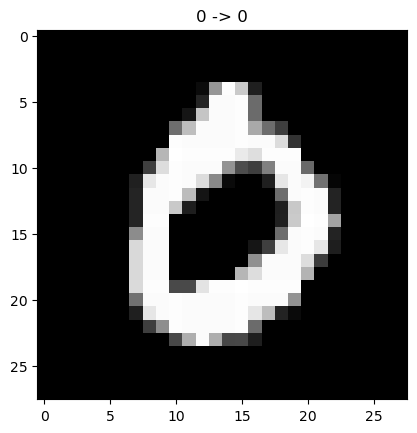

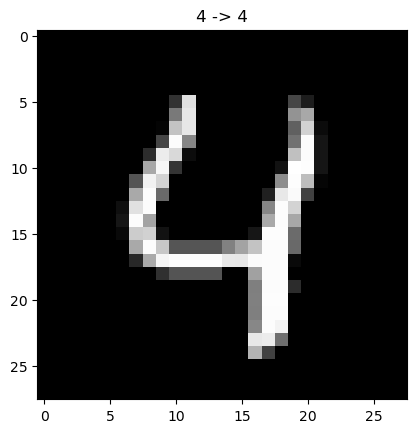

In [60]:
for i in range(5): # visualizing model's performance
    show_img(X_test[i], y_test[i],pred_test[i])

torch.Size([404, 28, 28])


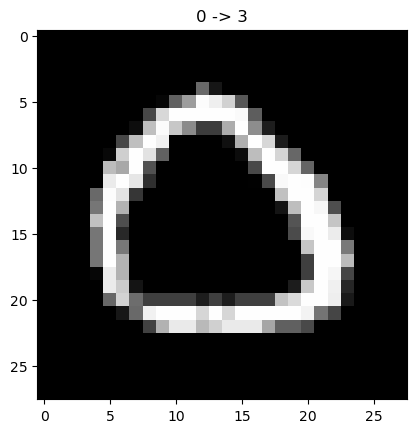

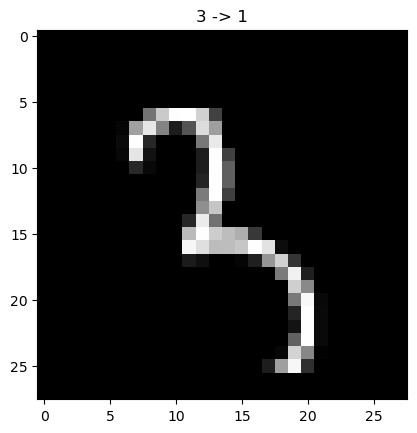

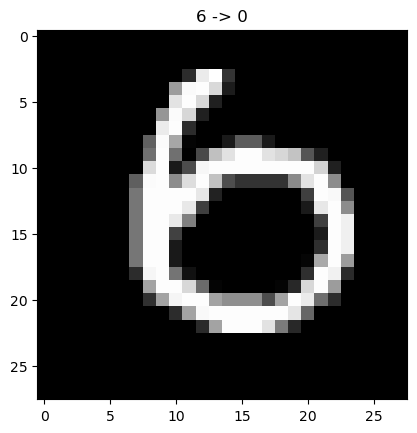

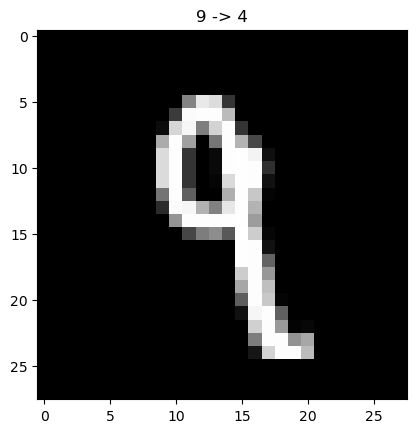

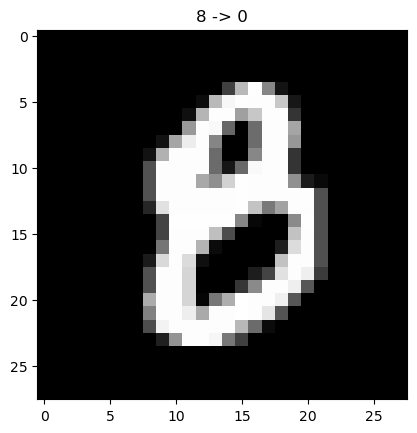

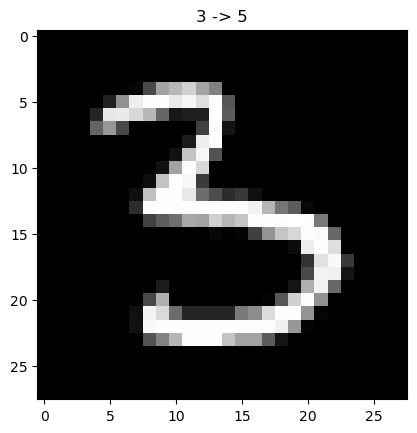

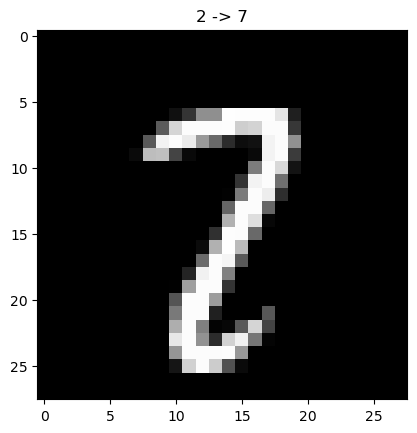

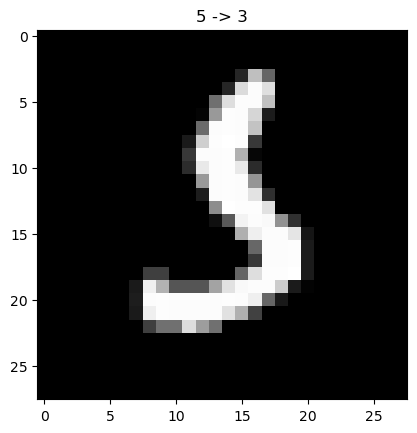

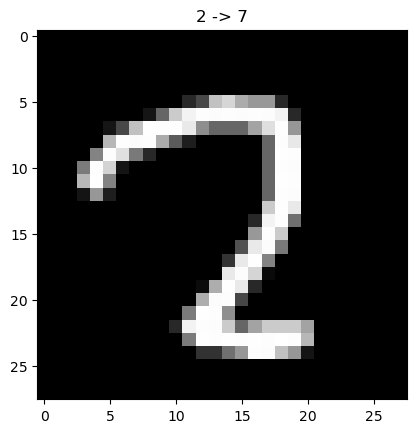

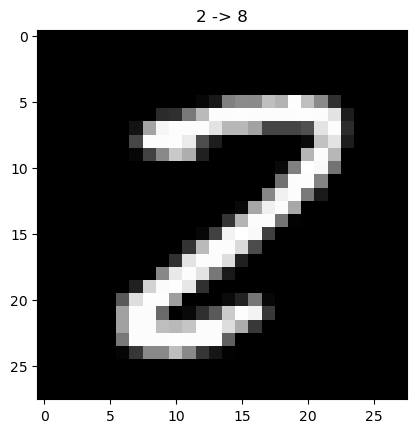

In [61]:
wrong_pred_index = (pred_test!=y_test)
wrong_preds = (X_test[wrong_pred_index], y_test[wrong_pred_index], pred_test[wrong_pred_index])
print(wrong_preds[0].size())
for i in range(10): # 10 instances which the model predicted wrongly
    show_img(wrong_preds[0][i], wrong_preds[1][i], wrong_preds[2][i])